# **Introduction**

This notebook is for implementing a Monte-Carlo reinforcement learning method on the Frozen Lake environment offered through the Gymnasium environment. Gymnasium is an open source Python library for developing and comparing reinforcement learning algorithms, through the use of a standardized API. There are four key functions to Gymnasium, namely: ```make()```, ```Env.reset()```, ```Env.step()```, and ```Env.render()```.

As per its [introductory documentation](https://gymnasium.farama.org/introduction/basic_usage/), the core of Gymnasium lies in the high-level Python class ```Env```, which approximately represents a Markov Decision Process (MDP) from reinforcement learning theory. This class allows users of Gymnasium to start new episodes, take actions, and visualize the agent's current state. 

# **Import Packages**

This section imports the necessary packages.

In [400]:
# import these:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# **Environment Setup**

This section sets up the environment and defines the relevant functions needed for this implementation. 

In [401]:
# MC-Agent Class:
class GLIE_MC_Agent:
        # constructor:
        def __init__(self, env: gym.Env, gamma: float, es : bool, cr: bool):
                """
                this is the constructor for the agent. this agent is a monte-carlo agent, meaning that it averages the returns
                for each Q(s,a) at the end of the episode

                env: a gymnasium environment
                gamma: a float value indicating the discounting factor
                es: a boolean value indicating whether to use exploring starts or not
                cr: a boolean value indicating whether to use custom rewards or not
                        custom rewards are: -1 for holes, +10 for goal
                        default rewards are: +0 for holes, +1 for goal

                Q: the estimate of the action-value function q, initialized as zeros over all states and actions
                
                """
                # object parameters:
                self.env = env
                self.gamma = gamma
                self.es = es
                self.cr = cr

                # get the number of states, number of actions:
                nS, nA = env.observation_space.n, env.action_space.n

                # get the terminal spaces of the current map:
                desc = env.unwrapped.desc.astype('U1')
                chars = desc.flatten()
                self.terminal_states = [i for i, c in enumerate(chars) if c in ('H','G')]

                # tabular Q-values, and counter N(s,a):
                self.Q = np.zeros((nS, nA))
                self.visits = np.zeros((nS, nA), dtype = int)         # how many times I have been to a state, and taken an action         

                # return to the user the metrics about the environment:
                print(f"Action Space is: {env.action_space}")
                print(f"Observation Space is: {env.observation_space}\n")

        # function to perform epsilon-greedy probability assignment:
        def get_action_probs(self, Q):
                """ 
                this function does the epsilon-greedy probability assignment for the actions available in a given state

                Q: a np.ndarray corresponding to the action-values of the actions available in a given state

                p: probability of selecting each action
                
                """
                # get the number of available actions:
                m = len(Q)

                # assign each action a base probability of e/m
                p = np.ones(m)*(self.epsilon/m)

                # find the index of the best Q value
                best = np.argmax(Q)

                # give that one more probability by an amount equal to (1 - e):
                p[best] += 1.0 - self.epsilon

                # this way the "best" action has a probability of e/m + (1-e), meaning it will be chosen more often
                # whereas the others have a probability of e/m, so there is a probability that exploratory actions will be selected

                # return the probability of selecting each action:
                return p
        
        # epsilon-greedy policy function:
        def policy(self, state):
                """ 
                this is the epsilon-greedy policy itself, where it chooses an action based on the epsilon-greedy probabilities of each action

                state: just an int representing the current state, 0-3

                returns a randomly selected action

                """
                probs = self.get_action_probs(self.Q[state])    # for a given state, or row in Q
                # print(f"probabilities are: {probs}")            # print statement for debugging probabilities of row
                return np.random.choice(len(probs), p = probs)  # pick an action from the probabilities of each action
        
        # episode generation function:
        def generate_episode(self):
                """ 
                this function is used to generate and run through episodes. 

                returns a list of (obs, a, r) tuples

                """
                episode = []    # empty list for returns

                # exploring starts:
                if self.es:
                        non_terminals = [s for s in range(self.env.observation_space.n) if s not in self.terminal_states]
                        starting_state = np.random.choice(non_terminals)

                        # force env into starting state:
                        _, _ = self.env.reset()
                        self.env.unwrapped.s = starting_state 
                        obs = starting_state
                else:
                        obs, _ = self.env.reset()

                # flag for when to stop episode
                done = False

                while not done:
                        a = self.policy(obs)    # select an action based on the current state

                        next_obs, r, term, trunc, _ = self.env.step(a)    # take the action

                        # custom reward shaping:
                        if self.cr:
                                if term and r == 0:
                                        r = -1  # fell in hole
                                elif term and r == 1:
                                        r = 10.0  # reached goal

                        episode.append((obs, a, r))     # trajectories are given by {S_1, A_1, R_2, ... , S_T} 
                        obs = next_obs          # advance the state
                        done = term or trunc    # set done to True if term (terminal state) or trunc (environment cut episode short)

                # return episode information for GPI
                return episode
        
        def update_Q(self, episode):
                """ 
                this function updates the Q estimation using incremental every-visit MC at the end of an episode.

                episode: the (s, a, r) list

                """
                g = 0   # initial return value
                for (s, a, r) in reversed(episode):
                        g = r + self.gamma * g
                        self.visits[s, a] += 1
                        n = self.visits[s, a]
                        self.Q[s, a] += (g - self.Q[s, a]) / n
        
        # actual policy iteration:
        def GPI(self, num_episodes):
                """ 
                this function performs the generalized policy iteration, using GLIE evaluation and epsilon-greedy policy improvement

                num_episode: number of episodes to play out

                returns the updated Q values
                
                """
                for k in tqdm(range(num_episodes)):
                        # GLIE uses a decaying epsilon schedule:
                        # self.epsilon = max(0.1, 1 / (0.005*k + 1))
                        self.epsilon = 1.0 / (0.005*k + 1)

                        # 1) play out an entire episode:
                        episode = self.generate_episode()

                        # 2) perform incremental, every-visit MC after the episode to approximate Q(s,a):
                        self.update_Q(episode)

                return self.Q

# **Using the Environment**

This section utilizes the above object-oriented implementation of RL to create an environment, train an agent, and then visualize the final value function that was learned. 

In [402]:
# create training environment:
env = gym.make("FrozenLake-v1", is_slippery = False)

# instantiate the agent
agent = GLIE_MC_Agent(env = env, gamma = 0.99, es = False, cr = False)
num_episodes = 250000

# learn value functions using MC:
q = agent.GPI(num_episodes = num_episodes).round(3)

Action Space is: Discrete(4)
Observation Space is: Discrete(16)



100%|██████████| 250000/250000 [00:24<00:00, 10380.09it/s]


Print these learned value functions separately:

In [403]:
print(f"action-value function q: {q}\n")

action-value function q: [[0.689 0.945 0.614 0.685]
 [0.189 0.    0.729 0.17 ]
 [0.256 0.804 0.233 0.339]
 [0.308 0.    0.098 0.188]
 [0.794 0.957 0.    0.737]
 [0.    0.    0.    0.   ]
 [0.    0.921 0.    0.576]
 [0.    0.    0.    0.   ]
 [0.847 0.    0.968 0.844]
 [0.875 0.979 0.924 0.   ]
 [0.629 0.98  0.    0.685]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.944 0.99  0.906]
 [0.919 0.976 1.    0.944]
 [0.    0.    0.    0.   ]]



# **Visualize the Learned Policy**

Can now visualize the learned policy:

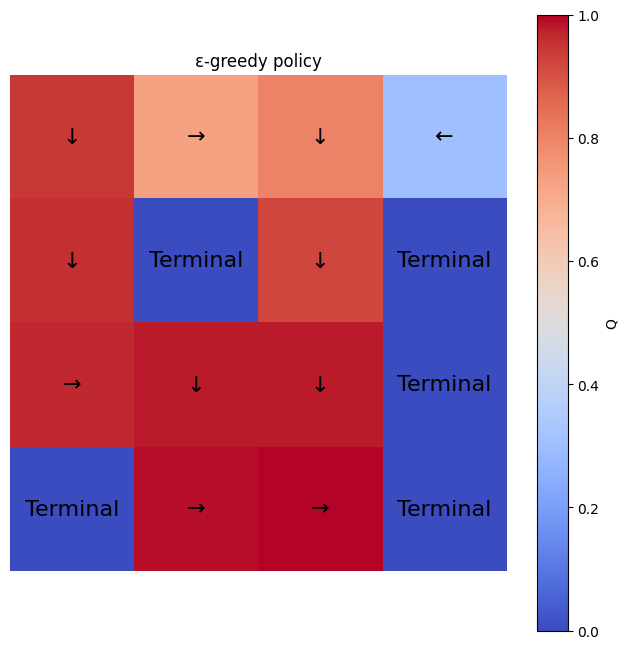

In [404]:
# define mapping of actions to directions:
action_map = {0: '←', 1: '↓', 2: '→', 3: '↑', None: 'Terminal'}
size = int(np.sqrt(agent.env.observation_space.n))
grid = np.zeros(agent.env.observation_space.n, dtype = object)

# for every state:
for s in range(agent.env.observation_space.n):
    if s in agent.terminal_states:
        action = None
    else:
        action = np.argmax(q[s, :])

    grid[s] = action_map[action]

# reshape to look like map
grid = grid.reshape(size, size)

# plot stuff:
fig, ax = plt.subplots(figsize = (2*size, 2*size))

# heatmap stuff:
heatmap_value = np.max(q, axis = 1).reshape((4,4))
heatmap = ax.imshow(heatmap_value, cmap = 'coolwarm', interpolation = 'nearest')

# overlay text:
for i in range(size):
    for j in range(size):
        text = grid[i, j]
        ax.text(j, i, text, ha = 'center', va = 'center', color = 'black', fontsize = 16)

# formatting:
fig.colorbar(heatmap, ax = ax, label = 'Q')
ax.set_title('ε-greedy policy')
ax.axis('off')

plt.show()